In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline  
from IPython.display import HTML

In [2]:
from sklearn.metrics import f1_score, roc_auc_score, average_precision_score, precision_score, recall_score
import pandas
import numpy as np
import papermill as pm
import json
import matplotlib.pyplot as plt
import os
import uuid
from db import Result
import ast
import math
from vis.visualization import visualize_cam, visualize_saliency, overlay
from vis.utils.utils import load_img, normalize, find_layer_idx


pandas.options.display.float_format = '{:,.3f}'.format

Using TensorFlow backend.


/home/user1/.local/share/virtualenvs/Bone-MRI-iLizu8rs/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/user1/.local/share/virtualenvs/Bone-MRI-iLizu8rs/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/user1/.local/share/virtualenvs/Bone-MRI-iLizu8rs/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", n

In [3]:
from evaluate import plot_learning_curve, plot_accuracy_curve, load, get_results, get_labels, transform_binary_probabilities, transform_binary_predictions, calculate_accuracy_loss, plot_confusion_matrix, plot_precision_recall, plot_roc_curve, calculate_pr_auc, calculate_confusion_matrix_stats, calculate_confusion_matrix, plot_tsne, plot_multiple_grad_cam, plot_precision_recall

In [4]:
from data_gen import data
from run import characterize_data
from config import config

In [5]:
# Parameters
UUID = "7e946fc2-5f5d-46b8-94e6-c57ea02f32ad"
SELECTIONS = "None"
TSNE_PERPLEXITY = 10


In [6]:
SELECTIONS = eval(SELECTIONS)

# Learning Curve

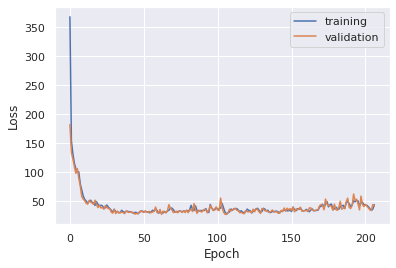

In [7]:
result = Result.query.filter(Result.uuid == UUID).first()
fig = plot_learning_curve(result)
fig.savefig("figures/learning_curves/{}-learning_curve.svg".format(UUID))

# Accuracy Trend

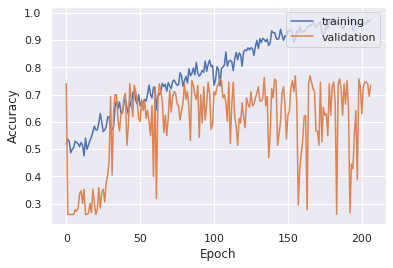

In [8]:
fig = plot_accuracy_curve(result)
fig.savefig("figures/accuracy/{}-accuracy.svg".format(UUID))

In [9]:
print("input form:", result.input_form)

input form: t2


In [10]:
MODEL = "{}/models/{}-{}.h5".format(config.OUTPUT, UUID, result.model)

In [ ]:
train, validation, test = data(seed=uuid.UUID(result.split_seed), label_form=result.label_form, input_form=result.input_form, train_shuffle=False, test_shuffle=False, validation_shuffle=False, train_augment=False, validation_augment=False, test_augment=False)

In [ ]:
print("training N:", len(train))
print("validation N:", len(validation))
print("test N:", len(test))

In [ ]:
class_inv = {v: k for k, v in train.class_indices.items()}
print("training {}:".format(class_inv[1]), sum(train.classes))
print("validation {}:".format(class_inv[1]), sum(validation.classes))
print("test {}:".format(class_inv[1]), sum(test.classes))

In [ ]:
model = load(MODEL)

In [ ]:
model

# Train

In [ ]:
results = get_results(model, train)

In [ ]:
probabilities = transform_binary_probabilities(results)
predictions = transform_binary_predictions(results)
labels = get_labels(train)
pm.record("train_labels", list(labels))
pm.record("train_probabilities", list(probabilities))
pm.record("train_predictions", list(predictions))

## Train statistics

In [ ]:
loss, accuracy = calculate_accuracy_loss(model, train)
print("Accuracy:", accuracy)
print("Loss:", loss)
stats = calculate_confusion_matrix_stats(labels, results)
pandas.DataFrame(stats, index=train.class_indices)

## Train confusion matrix

In [ ]:
fig = plot_confusion_matrix(train, results)
fig.savefig("figures/{}-{}-train-confusion-matrix.svg".format(result.uuid, result.input_form), bbox_inches = "tight")

## Train ROC curve

In [ ]:
fig = plot_roc_curve(labels, probabilities)
fig.savefig("figures/{}-{}-train-ROC-curve.svg".format(result.uuid, result.input_form), bbox_inches = "tight")

## Train precision-recall curve

In [ ]:
fig = plot_precision_recall(labels, results)
fig.savefig("figures/{}-{}-train-precisionrecall-curve.svg".format(result.uuid, result.input_form), bbox_inches = "tight")

# Validation

In [ ]:
results = get_results(model, validation)

In [ ]:
probabilities = transform_binary_probabilities(results)
predictions = transform_binary_predictions(results)
labels = get_labels(validation)
pm.record("validation_labels", list(labels))
pm.record("validation_probabilities", list(probabilities))
pm.record("validation_predictions", list(predictions))

## Validation statistics

In [ ]:
loss, accuracy = calculate_accuracy_loss(model, validation)
print("Accuracy:", accuracy)
print("Loss:", loss)
stats = calculate_confusion_matrix_stats(labels, results)
pandas.DataFrame(stats, index=validation.class_indices)

## Validation confusion matrix

In [ ]:
fig = plot_confusion_matrix(validation, results)
fig.savefig("figures/{}-{}-validation-confusion-matrix.svg".format(result.uuid, result.input_form), bbox_inches = "tight")

## Validation ROC curve

In [ ]:
fig = plot_roc_curve(labels, probabilities)
fig.savefig("figures/{}-{}-validation-ROC-curve.svg".format(result.uuid, result.input_form), bbox_inches = "tight")

## Validation precision-recall curve

In [ ]:
fig = plot_precision_recall(labels, results)
fig.savefig("figures/{}-{}-validation-precisionrecall-curve.svg".format(result.uuid, result.input_form), bbox_inches = "tight")

# Test

In [ ]:
results = get_results(model, test)

In [ ]:
probabilities = transform_binary_probabilities(results)
predictions = transform_binary_predictions(results)
labels = get_labels(test)
names = test.names
test_results = [['PatientID','True label','Predicted label','Probability']]
index = 0
for name in names:
    test_results.append([name, labels[index], predictions[index], probabilities[index]])
    index += 1
df = pandas.DataFrame(test_results)
df.to_csv("output/test_results/{}-{}.csv".format(UUID, result.model), header=False, index=False)
pm.record("test_labels", list(labels))
pm.record("test_probabilities", list(probabilities))
pm.record("test_predictions", list(predictions))

## Test statistics

In [ ]:
loss, accuracy = calculate_accuracy_loss(model, test)
print("Accuracy:", accuracy)
print("Loss:", loss)
stats = calculate_confusion_matrix_stats(labels, results)
pandas.DataFrame(stats, index=validation.class_indices)

## Test confusion matrix

In [ ]:
fig = plot_confusion_matrix(test, results)
fig.savefig("figures/{}-{}-test-confusion-matrix.svg".format(result.uuid, result.input_form), bbox_inches = "tight")

## Test ROC curve

In [ ]:
fig = plot_roc_curve(labels, probabilities)
fig.savefig("figures/{}-{}-test-ROC-curve.svg".format(result.uuid, result.input_form), bbox_inches = "tight")

## Test precision-recall curve

In [ ]:
fig = plot_precision_recall(labels, results)
fig.savefig("figures/{}-{}-test-precisionrecall-curve.svg".format(result.uuid, result.input_form), bbox_inches = "tight")

In [ ]:
import json
hyperparameters = json.loads(result.hyperparameters)
deep_top = hyperparameters["deep-dense-top"]
grad_cam_layer = "dense_3"
if deep_top: 
    grad_cam_layer = "dense_6"

# TSNE

# Grad Cam

In [ ]:
def show_grad_cam_images(images, labels, predictions, names=None, penultimate_layer="res5c_branch2c", layer="dense_3", columns=2, include_label=True):
    filter_idx = [0]
    grad_modifier = None
    backprop_modifier = None
    penultimate_layer_idx = None
    if penultimate_layer:
        penultimate_layer_idx = find_layer_idx(model, penultimate_layer)    
    rows = int(math.ceil(len(images) * 2/columns))
    f, ax = plt.subplots(rows, columns, figsize=(5.5, 3 * rows))    
    ax = ax.flatten()
    for i, image in enumerate(images): 
        grad = visualize_cam(
            model,
            find_layer_idx(model, layer),
            filter_idx,
            normalize(image),
            penultimate_layer_idx=penultimate_layer_idx,
            backprop_modifier=backprop_modifier,
            grad_modifier=grad_modifier)
        if names is not None: 
            ax[2*i].set_title("{}".format(names[i]))
        ax[2*i].imshow(image)
        ax[2*i].axis('off')
        if include_label: 
            ax[2*i+1].set_title("label/pred: {}/{}".format(labels[i], predictions[i]))
        ax[2*i+1].imshow(overlay(grad, image))
        ax[2*i+1].axis('off')
    return f, ax

In [ ]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')